<a href="https://colab.research.google.com/github/Papadopoulos18/CIFAR-10-with-Pytorch/blob/main/improving_with_data_augmentation_%26_batch_normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# using much larger CNN
# using data augmentation

In [23]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [24]:
transformer_train = torchvision.transforms.Compose([
  # torchvision.transforms.ColorJitter(
  #   brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
transforms.RandomCrop(32, padding=4),
torchvision.transforms.RandomHorizontalFlip(p=0.5),
# torchvision.transforms.RandomRotation(degrees=15),
torchvision.transforms.RandomAffine(0, translate=(0.1,0.1)),
# torchvision.transforms.RandomPerspective(),
transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(
    root = '.',
    train = True,
    transform=transformer_train,
    download=True
)

test_dataset = torchvision.datasets.CIFAR10(
    root = '.',
    train = False,
    transform=transforms.ToTensor(),
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
print(train_dataset.data.shape)
print(len(train_dataset.targets))   #targets are a list
print(test_dataset.data.shape)
print(len(test_dataset.data))

(50000, 32, 32, 3)
50000
(10000, 32, 32, 3)
10000


In [26]:
K = len(set(train_dataset.targets))     #train_dataset.targets->60000x1, .numpy->array([60000x1]),set->dict{0 to 9}
print(f'Number of classes are: {K}')

Number of classes are: 10


In [27]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [28]:
tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=1,
                                         shuffle=True)

for x, y in tmp_loader:
  print(x)
  print(x.shape)
  break

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.4980, 0.6000, 0.6745,  ..., 0.6157, 0.0000, 0.0000],
          ...,
          [0.6510, 0.7216, 0.6627,  ..., 0.8235, 0.0000, 0.0000],
          [0.6275, 0.6471, 0.6118,  ..., 0.8078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.4471, 0.5333, 0.6000,  ..., 0.5882, 0.0000, 0.0000],
          ...,
          [0.5529, 0.6275, 0.6078,  ..., 0.6431, 0.0000, 0.0000],
          [0.5961, 0.5922, 0.5176,  ..., 0.7216, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.3490, 0.4392, 0.5137,  ..., 0

In [33]:
from torch.nn.modules.activation import ReLU
from torch.nn.modules.linear import Linear
from torch.nn.modules import dropout
from torch.nn.modules.container import Sequential
class CNN(nn.Module):
  def __init__(self, K):
      super(CNN, self).__init__()

      # define the conv layers
      self.conv1 = nn.Sequential(
          nn.Conv2d(3, 32, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(32),
          nn.Conv2d(32, 32, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(32),
          nn.MaxPool2d(2)
      ) 

      self.conv2 = nn.Sequential(
          nn.Conv2d(32, 64, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.Conv2d(64, 64, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2)
      )

      self.conv3 = nn.Sequential(
          nn.Conv2d(64, 128, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(128),
          nn.Conv2d(128, 128, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(128),
          nn.MaxPool2d(2)

      )
# H_out = H_in + 2p - 2 --> p =1 if H_out = H_in

# Easy to calculate the output 
# 32 > 16 > 8 > 4         because of Max.Pool(2)
      
      #  Define the Linear Layers
      self.fc1 = nn.Linear(128 * 4 * 4, 1024)
      self.fc2 = nn.Linear(1024, K)


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1)               #out.size(0) -> batch size
    x = F.dropout(x, p=0.5)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.2)
    x = self.fc2(x)
    return x


# instantiate the model
model = CNN(K)

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [37]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs): 
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  
  for it in range(epochs):
    tO = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # print("inputs.shape: ", inputs.shape)

      # zero the parameter gradient
      optimizer.zero_grad()

      #forward pass
      outputs = model(inputs)
      # print("done getting the model output")
      # print("outputs.shape: ", outputs.shape, "targets.shape: ", targets.shape)
      loss = criterion(outputs, targets)

      # backward and optimize
      # print("about to optimize")
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    # get train loss and test loss
    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, targets in test_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - tO
    print(f'Epoch {it + 1}/{epochs}, Train Loss: {train_loss: .4f}, \
    Test Loss: {test_loss: .4f}, duration: {dt}')

  return train_losses, test_losses


train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=30) 


Epoch 1/30, Train Loss:  0.9931,     Test Loss:  0.8784, duration: 0:06:06.146056
Epoch 2/30, Train Loss:  0.8438,     Test Loss:  0.7975, duration: 0:06:02.858377
Epoch 3/30, Train Loss:  0.7498,     Test Loss:  0.7965, duration: 0:06:01.668889
Epoch 4/30, Train Loss:  0.6890,     Test Loss:  0.6948, duration: 0:06:02.031194
Epoch 5/30, Train Loss:  0.6345,     Test Loss:  0.7013, duration: 0:06:22.310375
Epoch 6/30, Train Loss:  0.6033,     Test Loss:  0.6369, duration: 0:06:02.283278
Epoch 7/30, Train Loss:  0.5659,     Test Loss:  0.5979, duration: 0:06:03.113025
Epoch 8/30, Train Loss:  0.5471,     Test Loss:  0.5871, duration: 0:06:02.390652
Epoch 9/30, Train Loss:  0.5208,     Test Loss:  0.5951, duration: 0:06:02.510738
Epoch 10/30, Train Loss:  0.5006,     Test Loss:  0.5677, duration: 0:06:02.163319
Epoch 11/30, Train Loss:  0.4896,     Test Loss:  0.5585, duration: 0:06:03.099466
Epoch 12/30, Train Loss:  0.4676,     Test Loss:  0.5790, duration: 0:06:02.664502
Epoch 13/30, 

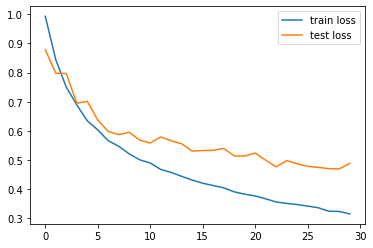

In [38]:
plt.plot(train_losses, label= 'train loss')
plt.plot(test_losses, label= 'test loss')
plt.legend()
plt.show()


In [39]:
n_correct = 0.
n_total = 0.
i=0

for inputs, targets in train_loader:
  i+=1
  # move the data to GPU
  inputs, targets = inputs.to(device), targets.to(device)
  if ( i==1):
    print(inputs.shape)
  # forward pass
  outputs = model(inputs)

  # get predictions
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct/n_total
# print("for ", i)
# print(inputs.shape)
# print(f'------{predictions.shape}--{outputs.shape}----{targets.shape}')
n_correct = 0
n_total = 0

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  # forward pass
  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct/n_total

print(f'Train acc: {train_acc: .4f}, Test acc: {test_acc: .4f}')


torch.Size([128, 3, 32, 32])
Train acc:  0.9002, Test acc:  0.8464


Confusion Matrix without normalization
[[891  20  17   9   9   3   3   6  32  10]
 [ 13 946   0   3   0   1   2   3   2  30]
 [ 57   5 748  46  42  29  52  15   2   4]
 [ 24   6  23 745  40  86  33  22  12   9]
 [ 16   1  25  32 850  22  30  19   2   3]
 [  7   1  18 125  29 755  18  41   2   4]
 [ 14   2  17  34  18  10 896   3   4   2]
 [ 17   2  14  28  34  21   6 869   3   6]
 [ 64  17   4   5   2   0   1   2 895  10]
 [ 26  72   2   6   0   0   1   2  14 877]]


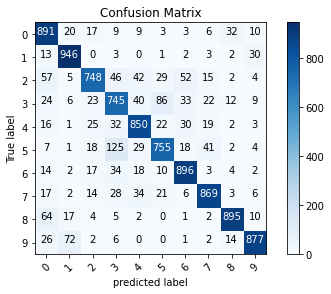

In [40]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
  
  # This function prints and plots the confusion matrix.
  # Normalization can be applied by setting 'normalize=True'

  if normalize:
    cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis])
    print('Normalize confusion Matrix')
  else:
    print('Confusion Matrix without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i,j], fmt),
             horizontalalignment="center",
             color="white" if cm[i,j] > thresh else "black")
    
  
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('predicted label')
  plt.show()


# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data
y_test = np.array(test_dataset.targets)
p_test = np.array([])
 
for inputs, targets in test_loader:
  # move date to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # forward pass
  outputs = model(inputs)

  # Get predictions
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [41]:
# label mapping 
labels = '''airplane,
Automobile,
bird,
Cat,
Deer,
dog,
frog,
horse,
Ship,
Truck'''.split("\n")


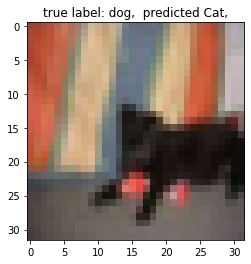

In [49]:
# show some misclassified examples

p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(32,32,3))
plt.title("true label: %s  predicted %s" % (labels[y_test[i]], labels[p_test[i]])); 

In [50]:
from torchsummary import summary

summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        MaxPool2d-14             [-1, 6